# Technological Innovation in Countries: A Data Analysis

**Author**: Álvaro González Frías

### Index

1. Introduction
2. Data Description
3. Exploratory Data Analysis
4. Data Prediction
5. Data Integration
6. Data Normalization
7. The Technological Innovation Index
8. Q1: Which factors are most important for innovation? A regression analysis
9. Statistical Tests
10. Q2: High-technology exports dependence: symbol of wealth or specialization? A graphical analysis
11. Conclusion


### Introduction

This study explores technological innovation across different countries, aiming to identify key factors that contribute to innovation and examine the role of high-tech exports in national economies. The study focuses on two main questions:

- **Q1: Which factors are most important for innovation?**
- **Q2: Is high-technology exports dependence a symbol of wealth or specialization?**

Technological progress is a key driver of economic growth and global influence. Countries invest heavily in research, development, and high-tech industries, but innovation is complex and influenced by various factors such as education, infrastructure, and policy.

Additionally, while some countries heavily rely on exporting high-tech products, this does not necessarily indicate a strong domestic innovation ecosystem. Understanding these dynamics can help businesses and researchers navigate global technological trends.

### Data Description

As our main dataset, we will be using the "Global Country Information Dataset 2023" after being cleaned and preprocessed in the notebook `01_introduction_and_processing.ipynb`. More details about the dataset can be found in that notebook.

This dataset does not contain information related to technological innovation, so we will integrate it with additional data from the World Bank's World Development Indicators database [[1]](https://databank.worldbank.org/). This database contains a wide range of indicators of different aspects of countries. There are three indicators that can be associated with technological innovation, which are the ones we will use in this study:

- **Scientific and technical journal articles**: number of scientific and engineering articles published in the following fields: physics, biology, chemistry, mathematics, clinical medicine, biomedical research, engineering and technology, and earth and space sciences. This indicator has an annual periodicity and is measured in number of articles.
- **High-technology exports (current US$)**: total value of high-technology product exports. These products include those with high research and development (R&D) intensity, such as aerospace, computers, pharmaceuticals, scientific instruments, and electrical machinery. This indicator has an annual periodicity and is measured in current US dollars.
- **High-technology exports (% of manufactured exports)**: percentage of high-tech product exports within the total manufactured exports of a country. This indicator has an annual periodicity and is measured in percentage.

It has been possible to export the data from the World Bank's World Development Indicators database, obtaining a CSV file for each indicator. In particular, each CSV file contains the values of the indicator for each country and year. There are a total of 217 countries in each CSV file, and the years range from 2012 to 2023. Next, we can see more details about the CSV files:

| File                          | Rows | Columns | Size  |
|-------------------------------|------|---------|-------|
| journal_articles.csv          | 217  | 18      | 32 KB |
| exports_values.csv            | 217  | 18      | 35 KB |
| exports_percentages.csv       | 217  | 18      | 52 KB |


### Exploratory Data Analysis


First, let's import the necessary libraries and load the main dataset, which has already been cleaned and preprocessed.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from polars import col
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from plotly.subplots import make_subplots

In [2]:
cleaned_data: pl.DataFrame = pl.read_csv("../data/cleaned/data.csv")

# Show the first 5 rows
cleaned_data.head()

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""",60.0,"""AF""",58.1,652230.0,323000.0,32.49,8672.0,149.9,2.3,4.47,2.1,0.7,1.9101e10,104.0,9.7,47.9,64.5,638.0,78.4,0.28,3.8041754e7,48.9,9.3,71.4,11.12,9.797273e6,33.93911,67.709953,853.74,"""AFG""",2021,10.0,0.0,132.0,246.0,45.0,94.0,104.0,39.0,16.0,1512.0,2188.0
"""Albania""",105.0,"""AL""",43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,78.5,15.0,56.9,1.2,2.854191e6,55.7,18.6,36.6,12.33,1.747593e6,41.153332,20.168331,832.84,"""ALB""",2021,68.0,50.0,246.0,379.0,261.0,695.0,580.0,87.0,47.0,985.0,3330.0
"""Algeria""",18.0,"""DZ""",17.4,2.381741e6,317000.0,24.28,150006.0,151.36,2.0,3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,76.7,112.0,28.1,1.72,4.3053054e7,41.2,37.2,66.1,11.7,3.15101e7,28.033886,1.659626,1148.84,"""DZA""",2021,27.000002,5.0000005,295.00003,616.00006,99.00001,276.00003,393.00006,109.000015,61.000008,1616.0001,3470.000314
"""Andorra""",164.0,"""AD""",40.0,468.0,45891.309773,7.2,469.0,144.87978,8.811619,1.27,34.0,1.51,3.1541e9,106.4,52.571065,2.7,84.04,-38.781461,36.4,3.33,77142.0,62.61806,19.248345,39.426857,6.042134,67873.0,42.506285,1.521801,3668.08,null,2021,68.0,191.0,425.0,876.0,375.0,522.0,221.0,113.0,13.0,816.0,3552.0
"""Angola""",26.0,"""AO""",47.5,1.2467e6,117000.0,40.73,34693.0,261.73,17.1,5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,60.8,241.0,33.4,0.21,3.1825295e7,77.5,9.2,49.1,6.89,2.1061025e7,-11.202692,17.873887,284.39,"""AGO""",2021,14.999997,72.999985,131.99997,313.99994,126.99998,15.999997,128.99997,809.9999,66.999985,704.9999,2372.999627


And now, let's do the same for the new datasets about technological innovation. The files that we will use are:

- `journal_articles.csv`
- `exports_percentages.csv`
- `exports_values.csv`

In [3]:
journal_articles: pl.DataFrame = pl.read_csv(
    "../data/raw/technological_innovation/journal_articles.csv"
)

# Show Spain as example
journal_articles.filter(col("Country Name") == "Spain").head()

Country Name,Country Code,Series Name,Series Code,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Spain""","""ESP""","""Scientific and technical journ…","""IP.JRN.ARTC.SC""","""54679.57""","""54727.56""","""56177.8""","""55305.66""","""55591.05""","""55884.36""","""57270.34""","""60307.51""","""65541.7""","""70281.94""","""67099.71""",""".."""


In [4]:
exports_values: pl.DataFrame = pl.read_csv(
    "../data/raw/technological_innovation/exports_values.csv"
)

# Show Spain as example
exports_values.filter(col("Country Name") == "Spain").head()

Country Name,Country Code,Series Name,Series Code,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Spain""","""ESP""","""High-technology exports (curre…","""TX.VAL.TECH.CD""","""13769965368""","""14480413179""","""14666986404""","""13111339617""","""15601713039""","""14946962289""","""15484719194""","""15037416553""","""15726202393""","""23457225215""","""33298624237""","""25806027599"""


In [5]:
exports_percentages: pl.DataFrame = pl.read_csv(
    "../data/raw/technological_innovation/exports_percentages.csv"
)

# Show Spain as example
exports_percentages.filter(col("Country Name") == "Spain").head()

Country Name,Country Code,Series Name,Series Code,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Spain""","""ESP""","""High-technology exports (% of …","""TX.VAL.TECH.MF.ZS""","""7.25080663420199""","""6.97005295956388""","""6.91215361464722""","""6.88833506484239""","""7.80248141094868""","""6.99949013494316""","""6.76693548745416""","""6.84640091103014""","""7.76842135531122""","""9.39320382214351""","""12.5837187911388""","""9.56253561613111"""


As we can see, the three new datasets have the same structure. The most relevant columns are the `Contry Name` and the different colums which include the values for the years from 2012 to 2023, so let's select only these columns and rename them to make it easier to work with them.

In [6]:
year_columns = {
    col: col[:4] for col in journal_articles.columns if col.startswith(("20"))
}

# Rename columns
journal_articles = journal_articles.rename({"Country Name": "Country"})
journal_articles = journal_articles.rename(year_columns)

exports_values = exports_values.rename({"Country Name": "Country"})
exports_values = exports_values.rename(year_columns)

exports_percentages = exports_percentages.rename({"Country Name": "Country"})
exports_percentages = exports_percentages.rename(year_columns)

# Select columns
journal_articles = journal_articles.select(["Country"] + list(year_columns.values()))
exports_values = exports_values.select(["Country"] + list(year_columns.values()))
exports_percentages = exports_percentages.select(
    ["Country"] + list(year_columns.values())
)

# Show example
print("Example of journal_articles:")
journal_articles.head()

Example of journal_articles:


Country,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
str,str,str,str,str,str,str,str,str,str,str,str,str
"""Afghanistan""","""34.65""","""27.31""","""35.01""","""21.19""","""59.55""","""72.4""","""90.34""","""139.36""","""145.71""","""177.39""","""169.19""",""".."""
"""Albania""","""150.63""","""148.81""","""154.14""","""159.48""","""165.44""","""133.42""","""170.56""","""203.1""","""167.16""","""241.09""","""238.59""",""".."""
"""Algeria""","""2998.95""","""3397.03""","""3618.61""","""4070.79""","""4447.92""","""5141.7""","""5291.25""","""6230.58""","""5709.84""","""6839""","""7606.65""",""".."""
"""American Samoa""","""..""","""..""","""..""","""..""","""..""","""..""","""..""","""..""","""..""","""..""","""..""",""".."""
"""Andorra""","""4.53""","""5.26""","""4.18""","""7.96""","""7.83""","""1.67""","""3.19""","""5.41""","""8.14""","""9.44""","""9.6""",""".."""


The columns data types are `str`. We need to convert them to `float`, except for the `Country` column, which we will keep as `str`. Note that null values ​​in the new datasets are represented by the string `..`, so we are going to replace them with null values.

In [7]:
columns_to_convert = [str(year) for year in range(2012, 2024)]

# Replace ".." with null and convert to float
journal_articles = journal_articles.with_columns(
    [
        pl.when(pl.col(year) == "..")  # Check if value is ".."
        .then(None)  # Replace with None (null)
        .otherwise(pl.col(year))  # Keep original value otherwise
        .cast(pl.Float64)  # Convert to float
        .alias(year)  # Rename column
        for year in columns_to_convert
    ]
)

exports_values = exports_values.with_columns(
    [
        pl.when(pl.col(year) == "..")
        .then(None)
        .otherwise(pl.col(year))
        .cast(pl.Float64)
        .alias(year)
        for year in columns_to_convert
    ]
)

exports_percentages = exports_percentages.with_columns(
    [
        pl.when(pl.col(year) == "..")
        .then(None)
        .otherwise(pl.col(year))
        .cast(pl.Float64)
        .alias(year)
        for year in columns_to_convert
    ]
)

# Show first 5 rows
print("Journal articles example:")
journal_articles.head()

Journal articles example:


Country,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""",34.65,27.31,35.01,21.19,59.55,72.4,90.34,139.36,145.71,177.39,169.19,null
"""Albania""",150.63,148.81,154.14,159.48,165.44,133.42,170.56,203.1,167.16,241.09,238.59,null
"""Algeria""",2998.95,3397.03,3618.61,4070.79,4447.92,5141.7,5291.25,6230.58,5709.84,6839.0,7606.65,null
"""American Samoa""",null,null,null,null,null,null,null,null,null,null,null,null
"""Andorra""",4.53,5.26,4.18,7.96,7.83,1.67,3.19,5.41,8.14,9.44,9.6,null


Remember that our main dataset has information only from 2023, so let's take a look at the null values in the new datasets for the year 2023.

In [8]:
# Count nulls in 2023
journal_articles_nulls = journal_articles.select(
    pl.col("2023").is_null().sum().alias("Nulls in 2023 journal_articles")
)
exports_values_nulls = exports_values.select(
    pl.col("2023").is_null().sum().alias("Nulls in 2023 exports_values")
)
exports_percentages_nulls = exports_percentages.select(
    pl.col("2023").is_null().sum().alias("Nulls in 2023 exports_percentages")
)

# Show nulls count
print(journal_articles_nulls)
print(exports_values_nulls)
print(exports_percentages_nulls)

shape: (1, 1)
┌────────────────────────────────┐
│ Nulls in 2023 journal_articles │
│ ---                            │
│ u32                            │
╞════════════════════════════════╡
│ 217                            │
└────────────────────────────────┘
shape: (1, 1)
┌──────────────────────────────┐
│ Nulls in 2023 exports_values │
│ ---                          │
│ u32                          │
╞══════════════════════════════╡
│ 81                           │
└──────────────────────────────┘
shape: (1, 1)
┌─────────────────────────────────┐
│ Nulls in 2023 exports_percenta… │
│ ---                             │
│ u32                             │
╞═════════════════════════════════╡
│ 82                              │
└─────────────────────────────────┘


Unfortunately, the new datasets have a lot of missing values for the year 2023. In order to solve this problem, we will try to predict these values using the data from the previous years. We will do a time series analysis, since it is the method that best fits this type of problem.

### Data Prediction

There are several approaches to analyzing time series data, like ARIMA method or some machine learning models, such as Random Forest or Neural Networks. In this case, we will use Prophet, a forecasting tool developed by Facebook [[2]](https://facebook.github.io/prophet/). Prophet is known for its flexibility and ability to produce reliable forecasts across a wide range of time series patterns.

We can start by defining a function that will receive a Polars dataframe with the Prophet-required structure, train a model for each country, and predict the missing values for the year 2023. Note that we will only predict data if we have at least 4 years of data available, in order to avoid non-reliable predictions.

In [9]:
def forecast_prophet(df: pl.DataFrame) -> pl.DataFrame:
    import logging

    logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

    df = df.to_pandas()
    predictions = []

    for country, group in df.groupby("Country"):
        group = group.dropna()
        if len(group) < 4:
            continue  # Skip countries without enough data

        # Prepare data for Prophet
        df_prophet = group.rename(columns={"Year": "ds", "Value": "y"})
        df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

        # Train model
        model = Prophet()
        model.fit(df_prophet)

        # Make prediction for 2023
        future = pd.DataFrame({"ds": [pd.to_datetime("2023")]})
        forecast = model.predict(future)

        # Store prediction
        predictions.append({"Country": country, "2023": forecast["yhat"].values[0]})

    df_predictions = pl.DataFrame(predictions)

    return df_predictions

Before we start the prediction process, we need to make some adjustments to the data. We will drop the 2023 column, since we will predict its values. We will also unpivot the data, so that we have a column for the year and another for the value, as required by Prophet.

In [10]:
# Eliminate 2023 column
journal_articles = journal_articles.drop("2023")
exports_values = exports_values.drop("2023")
exports_percentages = exports_percentages.drop("2023")

# Unpivot data
journal_articles_unpivot = journal_articles.unpivot(
    index=["Country"],
    on=journal_articles.columns[1:],
    variable_name="Year",
    value_name="Value",
)

exports_values_unpivot = exports_values.unpivot(
    index=["Country"],
    on=exports_values.columns[1:],
    variable_name="Year",
    value_name="Value",
)

exports_percentages_unpivot = exports_percentages.unpivot(
    index=["Country"],
    on=exports_percentages.columns[1:],
    variable_name="Year",
    value_name="Value",
)

# Show 5 first rows
print("Journal articles example:")
journal_articles_unpivot.head()

Journal articles example:


Country,Year,Value
str,str,f64
"""Afghanistan""","""2012""",34.65
"""Albania""","""2012""",150.63
"""Algeria""","""2012""",2998.95
"""American Samoa""","""2012""",null
"""Andorra""","""2012""",4.53


Now, we are ready to predict the missing values for the year 2023. Let's run the function we defined for each of the three datasets.

In [36]:
# Forecast 2023 journal articles
journal_articles_2023 = forecast_prophet(journal_articles_unpivot)

In [12]:
# Forecast 2023 exports values
exports_values_2023 = forecast_prophet(exports_values_unpivot)

In [13]:
# Forecast 2023 exports percentages
exports_percentages_2023 = forecast_prophet(exports_percentages_unpivot)

We have successfully obtained the predicted values for the year 2023. Our next step is to include this data in the main dataset.

### Data Integration

First, let's see how many countries we have predicted data for in each dataset.

In [14]:
print(f"Journal Articles: {len(journal_articles_2023)}")
print(f"Exports Percentages: {len(exports_percentages_2023)}")
print(f"Exports Values: {len(exports_values_2023)}")

Journal Articles: 197
Exports Percentages: 172
Exports Values: 173


As we can see, we have not predicted data for the same number of countries in the three datasets. Remember that we established a minimum of 4 years of data to make a prediction. Since we do not have reliable data to predict the missing values for these countries, we will only have into account the countries for which we have predicted data in all three datasets, so let's perform an inner join between the three datasets to keep only these countries.

In [15]:
# Join forecasts
forecasts = journal_articles_2023.join(exports_values_2023, on="Country", how="inner")
forecasts = forecasts.rename(
    {"2023": "Tech journal articles", "2023_right": "High-technology exports ($)"}
)

forecasts = forecasts.join(exports_percentages_2023, on="Country", how="inner")
forecasts = forecasts.rename({"2023": "High-technology exports (%)"})

# Show information
print("Number of countries:", len(forecasts))
forecasts.head()

Number of countries: 166


Country,Tech journal articles,High-technology exports ($),High-technology exports (%)
str,f64,f64,f64
"""Albania""",226.04752,1.3563e6,0.044009
"""Algeria""",7609.395624,1.2244e7,0.999012
"""Andorra""",9.050005,4.6035e7,23.434979
"""Angola""",49.082585,4.4593e7,25.684862
"""Antigua and Barbuda""",8.143006,1419.876886,0.079357


Before continuing, we must also check if we have obtained any negative values in the predicted data, which does not make sense in this context.

In [16]:
# Check if we have negative values
journal_articles_negative = forecasts.filter(col("Tech journal articles") < 0)
exports_values_negative = forecasts.filter(col("High-technology exports ($)") < 0)
exports_percentages_negative = forecasts.filter(col("High-technology exports (%)") < 0)

print("Negative values in Tech journal articles:", len(journal_articles_negative))
print("Negative values in High-technology exports ($):", len(exports_values_negative))
print(
    "Negative values in High-technology exports (%):", len(exports_percentages_negative)
)

Negative values in Tech journal articles: 0
Negative values in High-technology exports ($): 9
Negative values in High-technology exports (%): 11


We have some negative values in the `High-technology exports ($)` and `High-technology exports (%)` columns. That could have happened because the model exaggerated some negative trends in the data. We will remove the countries with negative values from the dataset to avoid influence of these values in the analysis.

In [17]:
# Remove rows with negative values
forecasts = forecasts.filter(col("High-technology exports ($)") >= 0)
forecasts = forecasts.filter(col("High-technology exports (%)") >= 0)

# Show number of countries
print("Number of countries:", len(forecasts))

Number of countries: 153


As a result, we have technological innovation data for 153 countries. Now, we can try to integrate the predicted data into the main dataset. We will perform a left join between the main dataset and the forecasts, using the `Country` column as the key.

In [18]:
data = cleaned_data.join(forecasts, on="Country", how="left")

# Cout rows where we have integrated the technological innovation data
rows_with_technological_innovation = data.filter(
    col("Tech journal articles").is_not_null()
)
print(
    "Rows with technological innovation data:", len(rows_with_technological_innovation)
)

Rows with technological innovation data: 131


We had technological innovation data for 153 countries, but it looks like we could only integrate data for 131 countries. There are two reasons why this could have happened:

- The country names are not exactly the same in the two datasets.
- We have predicted data for countries that are not present in the main dataset.

Let's take a deeper look at this issue. We can start by obtaining the list of countries for which we have predicted data but could not integrate it into the main dataset.

In [19]:
not_integrated_data = forecasts.filter(
    ~pl.col("Country").is_in(
        rows_with_technological_innovation.select("Country").to_series()
    )
)

print("Countries without integrated data:", len(not_integrated_data))

not_integrated_data.write_csv(
    "../data/raw/technological_innovation/not_integrated_data.csv"
)

Countries without integrated data: 22


We will fix the differences in the country names by renaming the countries in the not integrated data, which can be easily identified in the csv file we just created. We will also remove the countries that are not present in the main dataset, which are Greenland and West Bank and Gaza.

In [20]:
# Rename countries
forecasts = forecasts.with_columns(
    forecasts["Country"].replace(
        [
            "Bahamas, The",
            "Cote d'Ivoire",
            "Cabo Verde",
            "Congo, Rep.",
            "Congo, Dem. Rep.",
            "Czechia",
            "Egypt, Arab Rep.",
            "Gambia, The",
            "Iran, Islamic Rep.",
            "Ireland",
            "Kyrgyz Republic",
            "Lao PDR",
            "Russian Federation",
            "St. Lucia",
            "St. Vincent and the Grenadines",
            "Slovak Republic",
            "Korea, Rep.",
            "Turkiye",
            "Viet Nam",
            "Yemen, Rep.",
        ],
        [
            "The Bahamas",
            "Ivory Coast",
            "Cape Verde",
            "Republic of the Congo",
            "Democratic Republic of the Congo",
            "Czech Republic",
            "Egypt",
            "The Gambia",
            "Iran",
            "Republic of Ireland",
            "Kyrgyzstan",
            "Laos",
            "Russia",
            "Saint Lucia",
            "Saint Vincent and the Grenadines",
            "Slovakia",
            "South Korea",
            "Turkey",
            "Vietnam",
            "Yemen",
        ],
    )
)

# Remove rows
forecasts = forecasts.filter(
    ~pl.col("Country").is_in(["Greenland", "West Bank and Gaza"])
)

Let's try to integrate the data again.

In [21]:
data = cleaned_data.join(forecasts, on="Country", how="left")

# Cout rows where we have integrated the technological innovation data
rows_with_technological_innovation = data.filter(
    col("Tech journal articles").is_not_null()
)
print(
    "Rows with technological innovation data:", len(rows_with_technological_innovation)
)

Rows with technological innovation data: 151


Now, we have 151 countries with technological innovation data, which is the expected result after eliminating the two countries that are not present in the main dataset. We can now filter the main dataset to keep only the columns with technological innovation data, and proceed with the analysis after a successful integration.

In [22]:
data = data.filter(col("Tech journal articles").is_not_null())

### Data Normalization

Two of the new columns, Tech Journal Articles and High-technology exports ($), are absolute values, which means that countries with larger populations will tend to have larger values. This could introduce a bias in the analysis, so we will normalize these columns by dividing them by the population of each country, calculating the values per capita.

In [23]:
# Normalize data
data = data.with_columns(
    (pl.col("Tech journal articles") / pl.col("Population")).alias(
        "Tech journal articles per capita"
    ),
    (pl.col("High-technology exports ($)") / pl.col("Population")).alias(
        "High-technology exports ($) per capita"
    ),
)

# Drop columns
data = data.drop(["Tech journal articles", "High-technology exports ($)"])

# Show first 5 rows
data.head()

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion,High-technology exports (%),Tech journal articles per capita,High-technology exports ($) per capita
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Albania""",105.0,"""AL""",43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,78.5,15.0,56.9,1.2,2.854191e6,55.7,18.6,36.6,12.33,1.747593e6,41.153332,20.168331,832.84,"""ALB""",2021,68.0,50.0,246.0,379.0,261.0,695.0,580.0,87.0,47.0,985.0,3330.0,0.044009,0.000079,0.475195
"""Algeria""",18.0,"""DZ""",17.4,2.381741e6,317000.0,24.28,150006.0,151.36,2.0,3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,76.7,112.0,28.1,1.72,4.3053054e7,41.2,37.2,66.1,11.7,3.15101e7,28.033886,1.659626,1148.84,"""DZA""",2021,27.000002,5.0000005,295.00003,616.00006,99.00001,276.00003,393.00006,109.000015,61.000008,1616.0001,3470.000314,0.999012,0.000177,0.284388
"""Andorra""",164.0,"""AD""",40.0,468.0,45891.309773,7.2,469.0,144.87978,8.811619,1.27,34.0,1.51,3.1541e9,106.4,52.571065,2.7,84.04,-38.781461,36.4,3.33,77142.0,62.61806,19.248345,39.426857,6.042134,67873.0,42.506285,1.521801,3668.08,null,2021,68.0,191.0,425.0,876.0,375.0,522.0,221.0,113.0,13.0,816.0,3552.0,23.434979,0.000117,596.758577
"""Angola""",26.0,"""AO""",47.5,1.2467e6,117000.0,40.73,34693.0,261.73,17.1,5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,60.8,241.0,33.4,0.21,3.1825295e7,77.5,9.2,49.1,6.89,2.1061025e7,-11.202692,17.873887,284.39,"""AGO""",2021,14.999997,72.999985,131.99997,313.99994,126.99998,15.999997,128.99997,809.9999,66.999985,704.9999,2372.999627,25.684862,0.000002,1.401174
"""Antigua and Barbuda""",223.0,"""AG""",20.5,443.0,0.0,15.33,557.0,113.81,1.2,1.99,22.3,0.99,1.7278e9,105.0,24.8,5.0,76.9,42.0,24.3,2.76,97118.0,63.316599,16.5,43.0,6.822771,23800.0,17.060816,-61.796428,1548.15,"""ATG""",2021,66.99353,126.98774,264.97443,418.95956,437.9577,198.9808,211.97954,51.99498,4.9995174,622.9399,2339.774167,0.079357,0.000084,0.01462


Other colums from the main dataset are also absolute values, so we will normalize them as well. We will do the following transformations:

- `Armed Forces size` -> `Armed Forces size (%)`
- `Co2-Emissions` -> `Co2-Emissions per capita`
- `GDP` -> `GDP per capita`
- `Urban population` -> `Urban population (%)`

In [24]:
# Normalize data
data = data.with_columns(
    (pl.col("Armed Forces size") * 100 / pl.col("Population")).alias(
        "Armed Forces size (%)"
    ),
    (pl.col("Co2-Emissions") / pl.col("Population")).alias("Co2-Emissions per capita"),
    (pl.col("GDP") / pl.col("Population")).alias("GDP per capita"),
    (pl.col("Urban population") * 100 / pl.col("Population")).alias(
        "Urban population (%)"
    ),
)

# Drop columns
data = data.drop(["Armed Forces size", "Co2-Emissions", "GDP", "Urban population"])

# Show first 5 rows
data.head()

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Birth Rate,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion,High-technology exports (%),Tech journal articles per capita,High-technology exports ($) per capita,Armed Forces size (%),Co2-Emissions per capita,GDP per capita,Urban population (%)
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Albania""",105.0,"""AL""",43.1,28748.0,11.78,119.05,1.4,1.62,28.1,1.36,107.0,55.0,7.8,78.5,15.0,56.9,1.2,2.854191e6,55.7,18.6,36.6,12.33,41.153332,20.168331,832.84,"""ALB""",2021,68.0,50.0,246.0,379.0,261.0,695.0,580.0,87.0,47.0,985.0,3330.0,0.044009,0.000079,0.475195,0.315326,0.001589,5352.857411,61.229014
"""Algeria""",18.0,"""DZ""",17.4,2.381741e6,24.28,151.36,2.0,3.02,0.8,0.28,109.9,51.4,20.1,76.7,112.0,28.1,1.72,4.3053054e7,41.2,37.2,66.1,11.7,28.033886,1.659626,1148.84,"""DZA""",2021,27.000002,5.0000005,295.00003,616.00006,99.00001,276.00003,393.00006,109.000015,61.000008,1616.0001,3470.000314,0.999012,0.000177,0.284388,0.736301,0.003484,3948.343279,73.189001
"""Andorra""",164.0,"""AD""",40.0,468.0,7.2,144.87978,8.811619,1.27,34.0,1.51,106.4,52.571065,2.7,84.04,-38.781461,36.4,3.33,77142.0,62.61806,19.248345,39.426857,6.042134,42.506285,1.521801,3668.08,null,2021,68.0,191.0,425.0,876.0,375.0,522.0,221.0,113.0,13.0,816.0,3552.0,23.434979,0.000117,596.758577,59.489396,0.00608,40886.391162,87.984496
"""Angola""",26.0,"""AO""",47.5,1.2467e6,40.73,261.73,17.1,5.52,46.3,0.97,113.5,9.3,51.6,60.8,241.0,33.4,0.21,3.1825295e7,77.5,9.2,49.1,6.89,-11.202692,17.873887,284.39,"""AGO""",2021,14.999997,72.999985,131.99997,313.99994,126.99998,15.999997,128.99997,809.9999,66.999985,704.9999,2372.999627,25.684862,0.000002,1.401174,0.367632,0.00109,2973.59116,66.176999
"""Antigua and Barbuda""",223.0,"""AG""",20.5,443.0,15.33,113.81,1.2,1.99,22.3,0.99,105.0,24.8,5.0,76.9,42.0,24.3,2.76,97118.0,63.316599,16.5,43.0,6.822771,17.060816,-61.796428,1548.15,"""ATG""",2021,66.99353,126.98774,264.97443,418.95956,437.9577,198.9808,211.97954,51.99498,4.9995174,622.9399,2339.774167,0.079357,0.000084,0.01462,0.0,0.005735,17790.309304,24.506271


### The Technological Innovation Index

In order to quantify the technological innovation of each country, we will create an innovation index that combines the variables Tech Journal Articles per capita and High-technology exports ($) per capita. The variable High-technology exports (%) will not be included, as it would introduce redundancy and inconsistency in units, given that the absolute value of exports per capita already captures the relevant information about technological output in a more direct manner.  However, we will keep this variable for further analysis, as it gives us information about the relative importance of high-technology exports in the total exports of each country.

Before creating the index, we will apply a min-max scaling to the two variables, so that they are in the same range. This will prevent one variable from dominating the other in the index calculation. To calculate the Technological Innovation Index, we will assign a weight of 0.5 to each variable.


In [25]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


# Scale data
data = data.with_columns(
    [
        min_max_scaling(pl.col("Tech journal articles per capita")).alias(
            "Tech journal articles per capita"
        ),
        min_max_scaling(pl.col("High-technology exports ($) per capita")).alias(
            "High-technology exports ($) per capita"
        ),
    ]
)

# Calculate Technological Innovation Index
data = data.with_columns(
    [
        (
            0.5 * pl.col("Tech journal articles per capita")
            + 0.5 * pl.col("High-technology exports ($) per capita")
        ).alias("Technological Innovation Index")
    ]
)

# Drop columns
data = data.drop(
    ["Tech journal articles per capita", "High-technology exports ($) per capita"]
)

### Q1: Which factors are most important for innovation? A regression analysis

The next step is to analyze the relationship between the Technological Innovation Index and the other variables in the main dataset, in order to answer our first question. We will perform a regression analysis to determine which factors are most important for innovation, but before that, we need to do a feature selection process to choose the most relevant variables. We will use Pearson's correlation coefficient for this purpose.


The selection criteria for the variables will be the following:

- C1: we will keep the variables with a correlation coefficient greater than 0.4 or less than -0.4 with the Technological Innovation Index.
- C2: we will also keep the variables that are not highly correlated with each other (correlation coefficient between -0.8 and 0.8) to avoid multicollinearity.

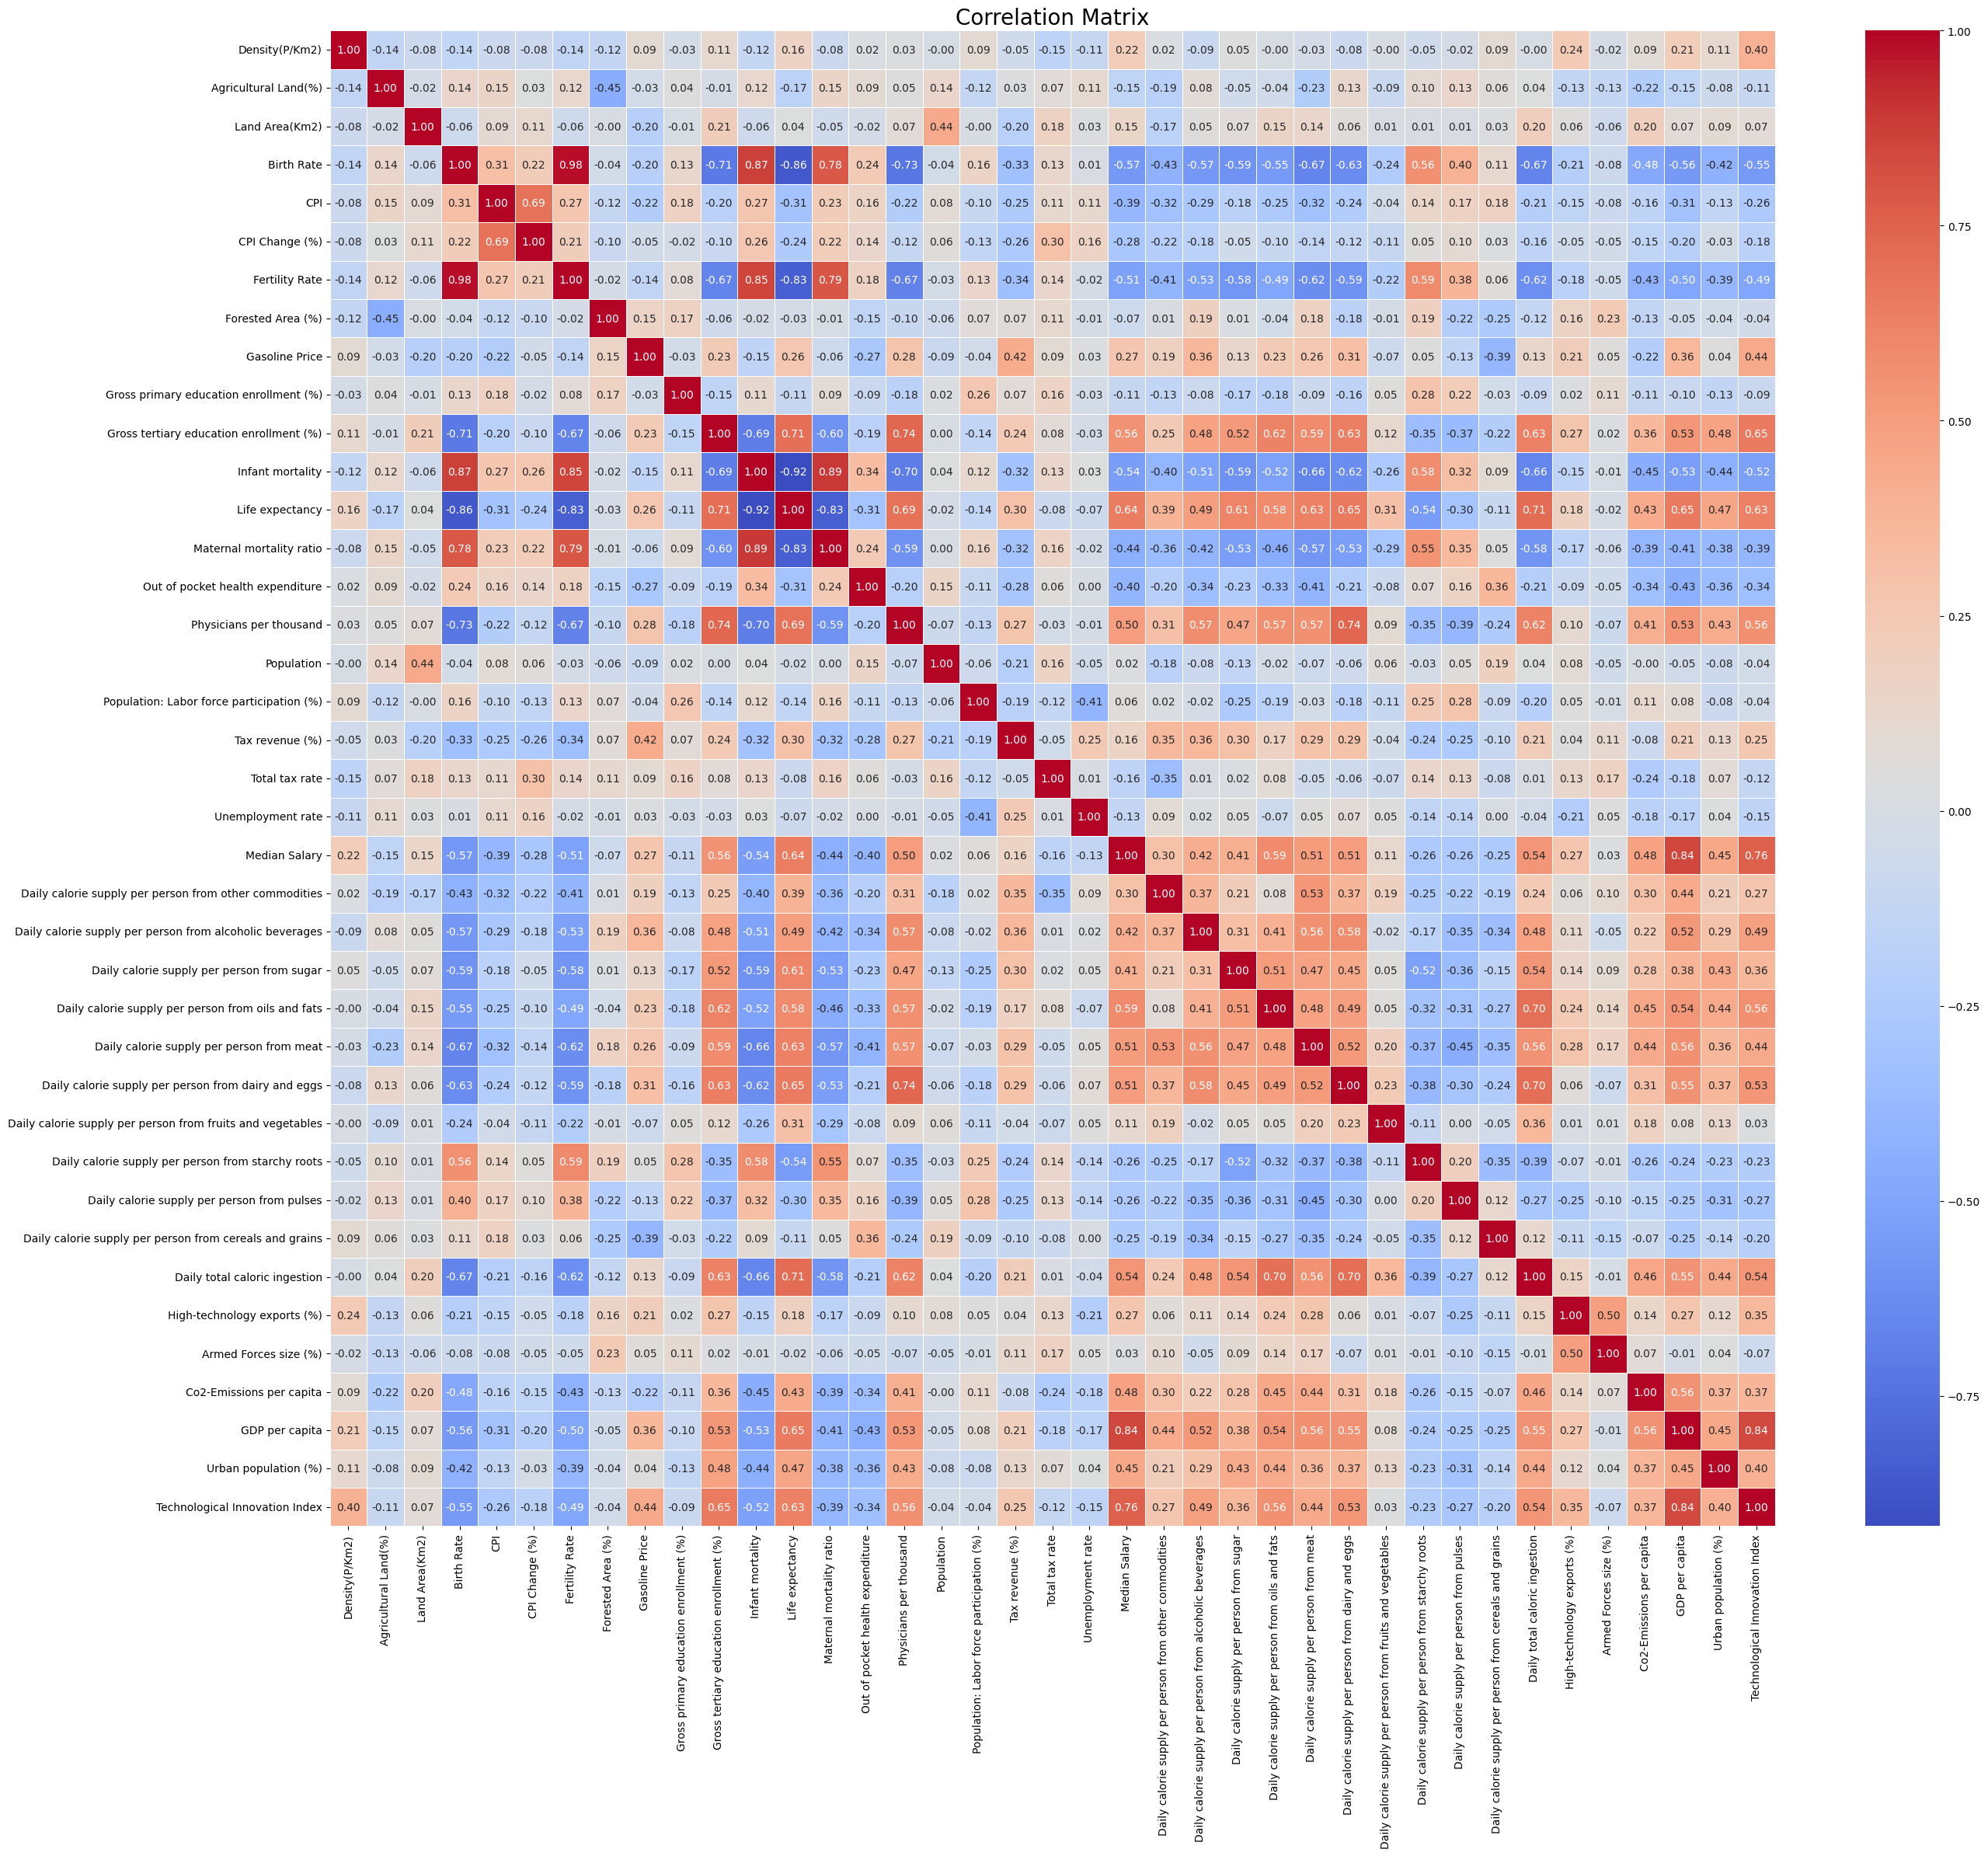

In [26]:
# Delete columns that are not needed for the correlation matrix
corr_data = data.drop(
    ["Country", "Abbreviation", "Code", "Year", "Latitude", "Longitude"]
)

# Convert to pandas
corr_data = corr_data.to_pandas()

# Calculate the correlation matrix using the Pearson's coefficient (default)
correlation_matrix = corr_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Correlation Matrix", fontsize=20)
plt.show()

Now, let's apply the feature selection criteria.

In [27]:
# Show variables that match C1
correlation_matrix["Technological Innovation Index"][
    (correlation_matrix["Technological Innovation Index"] > 0.4)
    | (correlation_matrix["Technological Innovation Index"] < -0.4)
]

Birth Rate                                                 -0.551464
Fertility Rate                                             -0.490303
Gasoline Price                                              0.439101
Gross tertiary education enrollment (%)                     0.653916
Infant mortality                                           -0.521823
Life expectancy                                             0.631909
Physicians per thousand                                     0.563319
Median Salary                                               0.759443
Daily calorie supply per person from alcoholic beverages    0.489768
Daily calorie supply per person from oils and fats          0.558881
Daily calorie supply per person from meat                   0.440399
Daily calorie supply per person from dairy and eggs         0.533723
Daily total caloric ingestion                               0.538061
GDP per capita                                              0.836070
Urban population (%)              

Taking a look at the variables that match C1 in the correlation matrix, we will not consider the variables that are highly correlated with each other, according to C2:

- `Birth rate` is highly correlated with `Fertility rate`, `Infant mortality`, and `Life expectancy`. We will only keep `Life expectancy`, as it is the most relevant variable for the Technological Innovation Index.
- `Median Salary` is highly correlated with `GDP per capita`. We will only keep `GDP per capita`, as it is the most relevant variable for the Technological Innovation Index.

In [28]:
# Select only the columns that match both C1 and C2
regression_data = data.select(
    [
        "Gasoline Price",
        "Gross tertiary education enrollment (%)",
        "Life expectancy",
        "Physicians per thousand",
        "Daily calorie supply per person from alcoholic beverages",
        "Daily calorie supply per person from oils and fats",
        "Daily calorie supply per person from meat",
        "Daily calorie supply per person from dairy and eggs",
        "Daily total caloric ingestion",
        "GDP per capita",
        "Urban population (%)",
        "Technological Innovation Index",
    ]
)

To evaluate the relationship between the selected variables and the Technological Innovation Index, we will use a Random Forest regression model, which allows us to analyze the importance of each variable in the prediction of the target variable. This model is suitable for this task because it can handle non-linear relationships between the variables and the target.

In [29]:
# Define features and target
features = [
    "Gasoline Price",
    "Gross tertiary education enrollment (%)",
    "Life expectancy",
    "Physicians per thousand",
    "Daily calorie supply per person from alcoholic beverages",
    "Daily calorie supply per person from oils and fats",
    "Daily calorie supply per person from meat",
    "Daily calorie supply per person from dairy and eggs",
    "Daily total caloric ingestion",
    "GDP per capita",
    "Urban population (%)",
]
X = regression_data.select(features).to_pandas()
y = regression_data["Technological Innovation Index"].to_pandas()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Random Forest R² Score: {r2}")
print(f"Random Forest MSE: {mse}")

# Calculate feature importances
importances = rf_model.feature_importances_

# Sort feature importances
importance_df = pl.DataFrame({"Feature": features, "Importance": importances})
importance_df = importance_df.sort("Importance", descending=True)
importance_df.to_pandas()

Random Forest R² Score: 0.7121487796893085
Random Forest MSE: 0.009798028246089328


,Feature,Importance
0,Life expectancy,0.466754
1,GDP per capita,0.290011
2,Gross tertiary education enrollment (%),0.083009
3,Daily calorie supply per person from oils and ...,0.058820
4,Daily calorie supply per person from alcoholic...,0.029644
5,Daily calorie supply per person from dairy and...,0.017966
6,Gasoline Price,0.014620
7,Daily total caloric ingestion,0.012717
8,Physicians per thousand,0.010202
9,Urban population (%),0.008970


The evaluation metrics of the model we have used are:

- **R² Score: 0.712** → Indicates that the model explains **71.2%** of the variance in the Innovation Index.
- **MSE: 0.0098** → Represents the average squared difference between predicted and actual values.

It looks like the model has a good performance, as it explains a high percentage of the variance in the Innovation Index. Now, let's analyze the most important variables for innovation according to the model:

1. **Life expectancy (46.7%)** → The most important factor. It may serve as an indicator of a country's development and well-being, affecting innovation.  
2. **GDP per capita (29.0%)** → A country's wealth directly impacts its ability to innovate.  
3. **Gross tertiary education enrollment (8.3%)** → Higher access to tertiary education correlates with increased innovation.  
4. **Daily calorie supply per person from oils and fats (5.8%)** → Could be linked to living standards and economic development.  
5. **Daily calorie supply per person from alcoholic beverages (2.9%)** → Perhaps in more innovative countries, there is greater access to alcohol consumption.  
6. **Gasoline Price (1.5%)** → Has a relatively small impact on innovation. 

The rest of the variables have a lower importance in the model.

### Statistical Tests

To ensure the reliability of the results, we will perform a statistical test to verify the significance of the variables in the model. We will apply the Permutation Importance method, which evaluates the importance of each feature by measuring the decrease in model performance when the values of that feature are randomly shuffled. We will establish the following hypotheses:

- Null Hypothesis (H0): The variable has not a significant impact on the Technological Innovation Index.
- Alternative Hypothesis (H1): The variable has a significant impact on the Technological Innovation Index.

We will use a significance level of 0.05, meaning that we will reject the null hypothesis if the p-value is less than 0.05.

In [30]:
# Calculate permutation importance
perm_importance = permutation_importance(
    rf_model, X_test, y_test, n_repeats=30, random_state=42
)

# Calculate p-values
p_values = np.array(
    [np.mean(perm_importance.importances[i] <= 0) for i in range(len(X_test.columns))]
)

# Create importance dataframe
importance_df_pvalues = pl.DataFrame(
    {
        "Feature": X_test.columns,
        "Importance": perm_importance.importances_mean,
        "P-value": p_values,
    }
)

# Show results
importance_df_pvalues = importance_df_pvalues.sort("P-value")
importance_df_pvalues.to_pandas()

,Feature,Importance,P-value
0,Gross tertiary education enrollment (%),0.104037,0.000000
1,Life expectancy,0.320907,0.000000
2,GDP per capita,0.228397,0.000000
3,Daily calorie supply per person from alcoholic...,0.009242,0.033333
4,Daily calorie supply per person from meat,0.002388,0.033333
5,Daily total caloric ingestion,0.003232,0.033333
6,Daily calorie supply per person from oils and ...,0.013784,0.066667
7,Physicians per thousand,0.002052,0.100000
8,Gasoline Price,0.002539,0.266667
9,Daily calorie supply per person from dairy and...,-0.000186,0.400000


The variables that are statistically significant (p-value < 0.05) according to the Permutation Importance test are:

- `Gross tertiary education enrollment (%)`
- `Life expectancy`
- `GDP per capita`
- `Daily calorie supply per person from alcoholic beverages`
- `Daily calorie supply per person from meat`
- `Daily total caloric ingestion`

From the results obtained in the Random Forest model and the Permutation Importance test, it looks like a high caloric ingestion may have a small positive impact on innovation. The statistical tests also confirm that gas prices have a low impact on innovation, as we stated before. Finally, the most relevant conclusion is that the Permutation Importance test has confirmed the high importance of three variables that were already identified as relevant by the Random Forest model: `Gross tertiary education enrollment (%)`, `Life expectancy`, and `GDP per capita`, so it looks like these variables are indeed significant for innovation.

### Q2: High-technology exports dependence: symbol of wealth or specialization? A graphical analysis

We also integrated the `High-technology exports (%)` variable into the main dataset, which gives us information about the relative importance of high-technology exports in the total exports of each country. We will analyze this variable to answer our second question: is the dependence on high-technology exports a symbol of wealth or specialization? We will compare the `High-technology exports (%)` variable with the `GDP per capita` variable to understand the relationship between them.

First, let's ensure that the `High-technology exports (%)` values we predicted are within the expected range (0-100).

In [31]:
# Check High-technology exports (%) values
exports_percentages = data.filter(
    (col("High-technology exports (%)") < 0)
    | (col("High-technology exports (%)") > 100)
)

exports_percentages.head()

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Birth Rate,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion,High-technology exports (%),Armed Forces size (%),Co2-Emissions per capita,GDP per capita,Urban population (%),Technological Innovation Index
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Palau""",39.0,"""PW""",10.9,459.0,14.0,118.17,1.3,2.21,87.6,1.093734,112.6,54.7,16.6,69.1,40.074779,21.8,1.18,18233.0,62.585974,21.3,76.6,6.505902,7.51498,134.58252,2380.0,null,2021,60.0,21.0,363.0,888.0,415.0,76.0,115.0,162.0,7.0,835.0,2882.0,109.52292,251.035063,0.012285,15575.873416,79.476773,0.0677


It looks like Palau's predicted value (109.52 %) is not within the expected range. This could be due to some missing data in the previous years, which could have negatively affected the prediction. We will remove this country from the analysis since the value is not reliable.

In [32]:
# Remove Palau
data = data.filter(col("Country") != "Palau")

Once we have verified the `High-technology exports (%)` values, we can proceed with the analysis. We will try to answer this question using some interesting visualizations, created with the help of the `plotly` library. We can start by ploting an interactive world map that shows the `High-technology exports (%)` for each country, which will give us a general idea of the distribution of this variable.

In [33]:
# Convert to pandas
df = data.to_pandas()

# Create a choropleth map
fig = px.choropleth(
    df,
    locations="Code",
    color="High-technology exports (%)",
    hover_name="Country",
    hover_data={
        "High-technology exports (%)": True,
        "Code": False,
    },
    color_continuous_scale="Plasma",
    title="High-technology exports (%) by country",
    projection="natural earth",
)

# Show map
fig.show()

As we can see, the more dependent countries on high-technology exports are located in Southeast Asia, while the less dependent countries are in South America, Africa, and the Middle East. However, it is important to note that there is a country in Africa, Central African Republic, with a high percentage of high-technology exports. We will have this country in mind for further analysis. On the other hand, the rest of Asia, Europe, and North America have a moderate dependence on high-technology exports, with countries like Iceland, Republic of Ireland, and South Korea standing out.

Next, we will display the same map, alongside another one illustrating the distribution of GDP per capita. This will allow us to extract some initial insights about the relationship between these two variables.

In [34]:
# Create subplots
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("High-tech Exports (%)", "GDP per Capita"),
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
)

# High-technology exports (%) map
fig.add_trace(
    go.Choropleth(
        locations=df["Code"],
        z=df["High-technology exports (%)"],
        text=df["Country"],
        colorscale="Plasma",
        colorbar_title="%",
        colorbar_x=0.45,
    ),
    row=1,
    col=1,
)

# GDP per capita map
fig.add_trace(
    go.Choropleth(
        locations=df["Code"],
        z=df["GDP per capita"],
        text=df["Country"],
        colorscale="Plasma",
        colorbar_title="USD",
        colorbar_x=1.02,
    ),
    row=1,
    col=2,
)

# Update layout
fig.update_layout(
    title_text="High-tech Exports (%) and GDP per Capita by Country",
    geo=dict(showcoastlines=True),
)

# Show figure
fig.show()

Looking at the two maps, we can observe some interesting patterns:

- **🟢 High GDP per capita and 🟡 moderate dependence on high-technology exports**: here, we find countries with a high GDP per capita and a considerable dependence on high-technology exports, but not as high as in Southeast Asia. These countries are mainly located in Europe and North America, with some exceptions like South Korea or Australia. In these countries, the export of technology seems to be accompanied by a strong economy. It indicates that they have advanced and diversified technological industries, which not only rely on exporting high-tech products but also generate added value through innovation and development.
- **🔴 Low GDP per capita and 🟢 high dependence on high-technology exports**: this group includes countries with a low GDP per capita and a high dependence on high-technology exports. We find here the Central African Republic and some countries in Southeast Asia. These countries may be specialized in the manufacturing and assembly of technology, without necessarily being the creators of innovation. Often, foreign companies set up factories in these countries due to their low production costs, but the wealth generated is not evenly distributed within the economy.
- **🟢 High GDP per capita and 🔴 low dependence on high-technology exports**: these countries have a high GDP per capita but a low dependence on high-technology exports. Some of them are Finland or Switzerland in Europe, and the United Arab Emirates or Qatar in the Middle East. The wealth of these countries comes from other sectors, such as energy (oil, gas), tourism, financial services, or raw materials. This suggests that a country can be prosperous without relying on technological exports, as long as it has other strong sources of income.
- **🔴 Low GDP per capita and 🔴 low dependence on high-technology exports**: this group includes countries with a low GDP per capita and a low dependence on high-technology exports, mainly located in Africa and South America. Some examples are Cameroon or Bolivia. These countries do not have a strong technological industry or other diversified economic sources. They often rely on exports of raw materials or agriculture, which makes them more vulnerable to changes in the global market.

Finally, we will create a scatter plot that shows the relationship between `High-technology exports (%)` and `GDP per capita` to confirm the patterns observed in the maps.

In [35]:
# Create scatter plot
fig = px.scatter(
    df,
    x="GDP per capita",
    y="High-technology exports (%)",
    hover_name="Country",
    title="High-technology exports (%) vs GDP per capita",
    trendline="ols",
)

# Show plot
fig.show()

From a general perspective, the scatter plot shows a positive correlation between `High-technology exports (%)` and `GDP per capita`, which means that countries with higher GDP per capita tend to have a higher dependence on high-technology exports. However, the relationship is not linear. For example, if we look at the countries located at the top left of the plot, we can see that they are Central African Republic some countries in Southeast Asia, confirming the pattern observed in the maps. On the other hand, countries like Finland, Switzerland, or the United Arab Emirates are located at the bottom right of the plot, showing that they have a high GDP per capita but a low dependence on high-technology exports.

### Conclusion

After completing the analysis, we can draw some conclusions about the questions we posed at the beginning of the study:

##### **Q1: Which factors are most important for innovation?**

The analysis revealed several key factors that play a significant role in driving innovation across countries. The most important factors identified were life expectancy, GDP per capita, and gross tertiary education enrollment:

- **Life expectancy** emerged as the most influential factor, highlighting the strong connection between a nation's overall well-being and its capacity for innovation. This suggests that countries with a healthier population may have more robust innovation ecosystems, likely because they benefit from higher productivity, better quality of life, and a more capable workforce.
- **GDP per capita** also played a crucial role, emphasizing that wealthier countries generally have more resources to invest in research, development, and technology. Wealth provides access to better infrastructure, more investment in education and research, and greater opportunities for innovation.
- **Gross tertiary education enrollment** proved to be another vital factor, reflecting the positive correlation between access to higher education and innovation. Countries with more people obtaining higher education tend to have a stronger base for technological advancements and the generation of new ideas.

Additionally, while variables such as daily calorie intake were considered, their impact was relatively smaller, suggesting that lifestyle factors may have a more indirect influence on innovation compared to structural factors like education and wealth.

In conclusion, the most significant drivers of innovation are health, education, and economic resources—all of which contribute to a fertile environment for technological progress and innovation.

##### **Q2: Is high-technology exports dependence a symbol of wealth or specialization?**

The analysis of the relationship between high-technology exports and GDP per capita suggests that the role of high-tech exports varies across different countries. The findings indicate that high-tech exports can be both a symbol of wealth and specialization, depending on the context of each country:

- In countries with **high GDP per capita** and **moderate dependence on high-tech exports** (e.g., many European countries, South Korea, and Australia), high-tech exports are often accompanied by a well-developed, diversified economy. These nations rely not just on exporting high-tech goods but also on generating added value through innovation and technological development. Here, high-tech exports reflect both wealth and the ability to innovate, as the export of technology is supported by strong, advanced industries.
- On the other hand, countries with **low GDP per capita** but **high dependence on high-tech exports** (e.g., the Central African Republic and some Southeast Asian nations) appear to be specialized in the manufacturing and assembly of technology rather than the creation of innovative products. These countries often have low production costs that attract foreign companies, but the wealth generated from these exports does not necessarily translate into broad economic prosperity. In this case, high-tech exports are more a symbol of specialization in specific sectors rather than overall wealth.
- Countries with **high GDP per capita** but **low dependence on high-tech exports** (e.g., Switzerland, Finland, and the UAE) show that it is possible to be wealthy without relying heavily on high-tech exports. These countries may find their wealth in other sectors, such as energy, tourism, or finance, which indicates that high-tech exports are not the sole indicator of a country's economic success or wealth.
- Finally, countries with both **low GDP per capita** and **low dependence on high-tech exports** (e.g., Cameroon, Bolivia) demonstrate limited technological development and economic diversification, often relying on exports of raw materials or agriculture.

In summary, the analysis suggests that high-tech exports are a symbol of specialization in some countries, particularly those with lower GDPs that focus on manufacturing, while in wealthier nations, they are more likely a symbol of both wealth and technological innovation.
